In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from utils_add_features import *
from utils_pipeline import *
from utils_evaluate import *


In [5]:
# X contain basic features, volumes and border of each segmentation as well as weight and age of each person.
X = pd.read_csv("TrainningInput_Dataset_myseg_area.csv",index_col = 0)
print(f"Original Feature from segmentation and MetaData :\n {X.columns.to_list()}\n\n")

y = pd.read_csv("TrainningOutput_Dataset_myseg_area.csv",index_col=0)
print(y.shape)


# Creation of new features
X = clean_features(X)
print(f"New Features :\n {X.columns.to_list()}\n\n")


# Same thing with the testing dataset :
X_test = pd.read_csv("TestingInput_Dataset_myseg_area.csv",index_col=0)
X_test = clean_features(X_test)

# Shuffle the data
X = X.sample(n=X.shape[0])
y = y.loc[X.index]


Original Feature from segmentation and MetaData :
 ['ED_RV_vol', 'ED_RV_border', 'ED_LV_vol', 'ED_LV_border', 'ED_MY_vol', 'ED_MY_border', 'ES_RV_vol', 'ES_RV_border', 'ES_LV_vol', 'ES_LV_border', 'ES_MY_vol', 'ES_MY_border', 'Height', 'Weight']


(100, 1)
Body surface area feature added
Finished adding feature

New Features :
 ['ED_RV_vol', 'ED_LV_vol', 'ED_MY_vol', 'ES_RV_vol', 'ES_LV_vol', 'ES_MY_vol', 'body_surface', 'ED_RV_vol_div_ED_LV_vol', 'ED_RV_vol_div_ED_MY_vol', 'ED_RV_vol_div_ES_RV_vol', 'ED_RV_vol_div_ES_LV_vol', 'ED_RV_vol_div_ES_MY_vol', 'ED_LV_vol_div_ED_MY_vol', 'ED_LV_vol_div_ES_RV_vol', 'ED_LV_vol_div_ES_LV_vol', 'ED_LV_vol_div_ES_MY_vol', 'ED_MY_vol_div_ES_RV_vol', 'ED_MY_vol_div_ES_LV_vol', 'ED_MY_vol_div_ES_MY_vol', 'ES_RV_vol_div_ES_LV_vol', 'ES_RV_vol_div_ES_MY_vol', 'ES_LV_vol_div_ES_MY_vol', 'ED_RV_vol_div_ED_RV_border', 'ED_LV_vol_div_ED_LV_border', 'ED_MY_vol_div_ED_MY_border', 'ES_RV_vol_div_ES_RV_border', 'ES_LV_vol_div_ES_LV_border', 'ES_MY_vol_div_ES_MY

In [ ]:
pipeline = ImbPipeline([
    ("dropcorrelationcolumns",HighCorrelationDropper())
    ("dataAugment",GaussianNoiseInjector()),
    ("normaliser" , MinMaxScaler()),
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'dataAugment', 'normaliser', 'classifier', 'dataAugment__noise_factor', 'normaliser__clip', 'normaliser__copy', 'normaliser__feature_range', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [4]:
cv = StratifiedKFold(shuffle=True,random_state=0)

In [4]:
param_grid = {
    'dataAugment__noise_factor' : [0.05,0.0],
    'classifier__n_estimators': [100,300,500,],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [2,3,5],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1,2],
}

In [25]:
search_spaces = {
    # clé = "étape__paramètre"  (nom__param dans un Pipeline)
    "classifier__n_estimators"    : Integer(50, 1000),
    "classifier__max_depth"       : Integer(2, 5),
    "classifier__min_samples_leaf": Integer(1, 2),
    "classifier__max_features"    : Real(0.1, 1.0, prior="uniform"),
    "classifier__bootstrap"       : Categorical([True]),
}

In [26]:
grid_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=20,              # 40 essais ≈ 8 × nb hyperparams
    cv=cv,
    scoring=make_scorer(accuracy_score),
    n_jobs=-1,              # parallélise les CV
    verbose=3,
    return_train_score=True,
)
grid_search.fit(X,y["Category"])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.4392045116118525, classifier__min_samples_leaf=2, classifier__n_estimators=858;, score=(train=0.963, test=0.900) total time=   6.3s
[CV 2/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.4392045116118525, classifier__min_samples_leaf=2, classifier__n_estimators=858;, score=(train=0.975, test=0.950) total time=   6.3s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.4392045116118525, classifier__min_samples_leaf=2, classifier__n_estimators=858;, score=(train=0.975, test=0.850) total time=   6.3s
[CV 1/5] END classifier__bootstrap=True, classifier__max_depth=3, classifier__max_features=0.4392045116118525, classifier__min_samples_leaf=2, classifier__n_estimators=858;, score=(train=0.988, test=0.850) total time=   6.3s
[CV 5/5] END classifier__bootstrap=True, 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
              estimator=Pipeline(steps=[('dataAugment',
                                         GaussianNoiseInjector()),
                                        ('normaliser', MinMaxScaler()),
                                        ('classifier',
                                         RandomForestClassifier())]),
              n_iter=20, n_jobs=-1, return_train_score=True,
              scoring=make_scorer(accuracy_score, response_method='predict'),
              search_spaces={'classifier__boots...
                             'classifier__max_depth': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'classifier__max_features': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'classifier__min_samples_leaf': Integer(low=1, high=2, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=50, high=1000, prior='uniform', transform='normalize')},
              verbose=3)

In [5]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=5,verbose=3,return_train_score=True)
grid_search.fit(X,y["Category"])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.05;, score=(train=0.963, test=0.900) total time=   0.4s
[CV 2/5] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.05;, score=(train=0.988, test=0.850) total time=   0.3s
[CV 3/5] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.05;, score=(train=0.950, test=0.900) total time=   0.4s
[CV 4/5] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100, dataAugment__noise_factor=0.05

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dataAugment', GaussianNoiseInjector()),
                                       ('normaliser', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [2, 3, 5],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [100, 300, 500],
                         'dataAugment__noise_factor': [0.05, 0.0]},
             return_train_score=True, verbose=3)

The model is fitted and now we want to properly evaluate the results. 
We select only the result from the best_params founded by the search. (Reminder that the best params are the one that provided the best mean validation score)

In [27]:
# set of parameters that gave the best cv result
best_params = grid_search.best_params_
print(f"best parameters : {best_params} ")

# Detailed result of the cross validation for each set of parameters
results = grid_search.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx = results['params'].index(best_params)
mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(f"score validation set : {mean_valid_score,std_valid_score}")
print(f"score trainning set : {mean_train_score,std_train_score}")

best parameters : OrderedDict({'classifier__bootstrap': True, 'classifier__max_depth': 4, 'classifier__max_features': 0.3821627121705027, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 835}) 
score validation set : (np.float64(0.9299999999999999), np.float64(0.024494897427831747))
score trainning set : (np.float64(1.0), np.float64(0.0))


In [28]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', MinMaxScaler()), ('classifier', RandomForestClassifier(max_depth=4, max_features=0.3821627121705027,
                       n_estimators=835))], 'transform_input': None, 'verbose': False, 'normaliser': MinMaxScaler(), 'classifier': RandomForestClassifier(max_depth=4, max_features=0.3821627121705027,
                       n_estimators=835), 'normaliser__clip': False, 'normaliser__copy': True, 'normaliser__feature_range': (0, 1), 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 4, 'classifier__max_features': 0.3821627121705027, 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 835, 'classifier__n_jobs': None

In [29]:
f_importance = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
f_name = grid_search.best_estimator_.named_steps["normaliser"].get_feature_names_out()
feature_importance = pd.DataFrame({
    "feature": f_name,
    "importance": f_importance
})
feature_importance.sort_values("importance", ascending=False, inplace=True)
print(feature_importance)

                       feature  importance
14     ED_LV_vol_div_ES_LV_vol    0.105710
10     ED_RV_vol_div_ES_LV_vol    0.104093
13     ED_LV_vol_div_ES_RV_vol    0.094579
16     ED_MY_vol_div_ES_LV_vol    0.091528
4                    ES_LV_vol    0.085101
7      ED_RV_vol_div_ED_LV_vol    0.070637
18     ES_RV_vol_div_ES_LV_vol    0.061571
8      ED_RV_vol_div_ED_MY_vol    0.060244
12     ED_LV_vol_div_ED_MY_vol    0.057584
11     ED_RV_vol_div_ES_MY_vol    0.057143
9      ED_RV_vol_div_ES_RV_vol    0.040289
15     ED_LV_vol_div_ES_MY_vol    0.037762
3                    ES_RV_vol    0.030119
1                    ED_LV_vol    0.029608
22  ES_RV_vol_div_ES_RV_border    0.023607
23  ES_LV_vol_div_ES_LV_border    0.008887
0                    ED_RV_vol    0.008074
2                    ED_MY_vol    0.007898
5                    ES_MY_vol    0.004330
19  ED_RV_vol_div_ED_RV_border    0.004236
20  ED_LV_vol_div_ED_LV_border    0.004078
17     ED_MY_vol_div_ES_MY_vol    0.003913
24  ES_MY_v

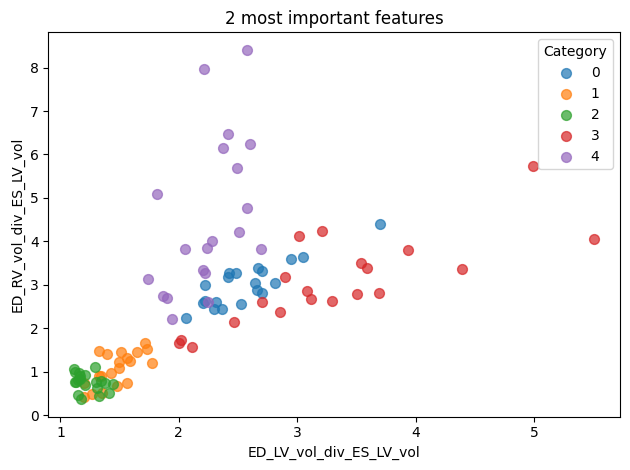

In [30]:
import matplotlib.pyplot as plt


df = X.copy()
# if y is a Series:
df['category'] = y["Category"]
# if y is a single‐column DataFrame instead, use:
# df['category'] = y['category_column_name']

# --- Option A: matplotlib only ---
fig, ax = plt.subplots()
for cat, sub in df.groupby('category'):
    F = feature_importance[:2]["feature"].to_list()
    F1,F2 = F[0],F[1]
    ax.scatter(sub[F1], sub[F2], label=cat, s=50, alpha=0.7)
ax.set_xlabel(F1)
ax.set_ylabel(F2)
ax.set_title('2 most important features')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

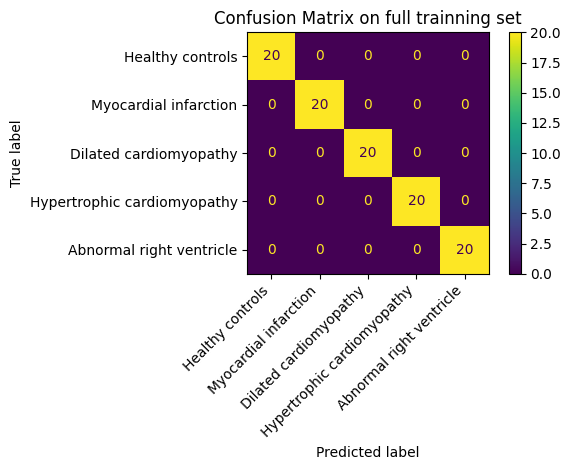

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [31]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

class_names = {0 : "Healthy controls",
                1: "Myocardial infarction",
                2: "Dilated cardiomyopathy",
                3: "Hypertrophic cardiomyopathy",
                4 : "Abnormal right ventricle"
}
labels = sorted(class_names.keys())
y_pred = inf_pipeline.predict(X)

disp = ConfusionMatrixDisplay.from_predictions(
    y["Category"], y_pred,
    display_labels=[class_names[i] for i in labels],     
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')
disp.ax_.set_title("Confusion Matrix on full trainning set")
plt.tight_layout()
plt.show()

print(classification_report(y["Category"],y_pred))

In [32]:
# Get the probabilities to get better insight on the model performance
proba = inf_pipeline.predict_proba(X)
print(f"average entropy score : {np.mean(certainty_score(proba))}")
print(f"\naverage margin score : {np.mean(margin_score(proba))}\n")
# Below 
treshold = 0.35
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > treshold : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
#print(proba)  
print(L)

average entropy score : 0.7831087315103017

average margin score : 0.8118172341899882

[1, 1, 1, 0, 1]


In [33]:
# Predict on the test set
import os

submission_name = "submission_21.csv"
submission_dataframe = pd.DataFrame(columns=["Id","Category"])
submission_dataframe["Id"] = X_test.index + 101

y_test_pred = inf_pipeline.predict(X_test)
submission_dataframe["Category"] = y_test_pred
submission_dataframe.to_csv(os.path.join(os.getcwd(),submission_name),index=False)

print("File saved")

File saved


Below two cells to save the results : the model and the description of the method used.

In [68]:
description = "Gaussian Noise + MinmaxScaler + Randomforest with Gridsearch." 
other_params = "The features are just the volume of each segmentation + body surface + all the possible ratios."
name_folder = "RF_1"
feature_used = f_name
informationDict = {
    "description": description,
    "model parameters" : best_params,
    "features used" : feature_used,
    "mean test accuracy with best params" : mean_valid_score ,
    "std  test with best params" : std_valid_score,
    "mean train accuracy with best params" : mean_train_score,
    "std train best params" : std_train_score,
    "other parms" : other_params,
    
}

In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

mask = y['Category'].isin([1, 2])
X_binary = X.loc[mask]
y_binary = y.loc[mask]


le = LabelEncoder()
y_binary = le.fit_transform(y_binary)

# print(X_binary.shape)
# X_binary.drop(columns=feature_importance[:5]["feature"].to_list(),inplace=True)
# print(X_binary.shape)


pipeline_binary_rf = Pipeline([
    ("dataAugment",GaussianNoiseInjector()),
    ("norm",MinMaxScaler()),
    ("classifier",RandomForestClassifier()),
])

pipeline_binary_svc = Pipeline([
    ("dataAugment",GaussianNoiseInjector()),
    ("norm",StandardScaler()),
    ("svc",SVC(probability=True)),
])

param_grid_binary_svc = {
    'dataAugment__noise_factor' : [0.1],
    'svc__C':       [5,7,10,15,20,50],
    'svc__kernel':  ['rbf'],
    'svc__gamma':   [0.01],
}

param_grid_binary_rf = {
    'dataAugment__noise_factor' : [0.05,0.0,0.1],
    'classifier__n_estimators': [50,100,300],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [3,5],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1,2],
}

param_grid_binary_xgb = {
    'xgb__n_estimators':    [100, 200],
    'xgb__max_depth':       [6],
    'xgb__learning_rate':   [0.01, 0.1, 0.2],
    'xgb__subsample':       [0.6, 0.8, 1.0],
    'xgb__colsample_bytree':[0.6, 0.8, 1.0],
    'xgb__gamma':           [0, 1, 5],
    'xgb__reg_alpha':       [0, 0.1, 1],
    'xgb__reg_lambda':      [1, 5, 10]
}
pipeline_binary_xgb = Pipeline([
    ("dataAugment",GaussianNoiseInjector()),
    ("norm",StandardScaler()),
    ("xgb",XGBClassifier()),
])

grid_search_binary = GridSearchCV(pipeline_binary_rf,param_grid=param_grid_binary_rf,cv=5,verbose=3,return_train_score=True)
grid_search_binary.fit(X_binary,y_binary)


/Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50, dataAugment__noise_factor=0.05;, score=(train=1.000, test=0.875) total time=   0.6s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50, dataAugment__noise_factor=0.05;, score=(train=1.000, test=0.625) total time=   0.2s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50, dataAugment__noise_factor=0.05;, score=(train=1.000, test=0.875) total time=   0.4s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50, dataAugment__noise_factor=0.05;, sc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dataAugment', GaussianNoiseInjector()),
                                       ('norm', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2],
                         'classifier__n_estimators': [50, 100, 300],
                         'dataAugment__noise_factor': [0.05, 0.0, 0.1]},
             return_train_score=True, verbose=3)

In [27]:
# set of parameters that gave the best cv result
best_params_binary = grid_search_binary.best_params_
print(f"best parameters : {best_params_binary} ")

# Detailed result of the cross validation for each set of parameters
results_binary = grid_search_binary.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx_binary = results_binary['params'].index(best_params_binary)
mean_train_score_binary = results_binary['mean_train_score'][best_idx_binary]
mean_valid_score_binary = results_binary['mean_test_score'][best_idx_binary]
std_train_score_binary = results_binary['std_train_score'][best_idx_binary]
std_valid_score_binary = results_binary['std_test_score'][best_idx_binary]
print(f"score validation set : {mean_valid_score_binary,std_valid_score_binary}")
print(f"score trainning set : {mean_train_score_binary,std_train_score_binary}")

best parameters : {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'dataAugment__noise_factor': 0.1} 
score validation set : (np.float64(0.95), np.float64(0.06123724356957946))
score trainning set : (np.float64(0.96875), np.float64(0.01976423537605237))


In [28]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline_binary = grid_search_binary.best_estimator_
inference_steps_binary = [
    (name, step)
    for name, step in best_pipeline_binary.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline_binary = Pipeline(inference_steps_binary)
print(inf_pipeline_binary.get_params())

{'memory': None, 'steps': [('norm', MinMaxScaler()), ('classifier', RandomForestClassifier(max_depth=5, min_samples_leaf=2))], 'transform_input': None, 'verbose': False, 'norm': MinMaxScaler(), 'classifier': RandomForestClassifier(max_depth=5, min_samples_leaf=2), 'norm__clip': False, 'norm__copy': True, 'norm__feature_range': (0, 1), 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 100, 'classifier__n_jobs': None, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__warm_start': False}


In [29]:
f_importance_binary = grid_search_binary.best_estimator_.named_steps["classifier"].feature_importances_
f_name_binary = grid_search_binary.best_estimator_.named_steps["norm"].get_feature_names_out()
feature_importance_binary = pd.DataFrame({
    "feature": f_name_binary,
    "importance": f_importance_binary
})
feature_importance_binary.sort_values("importance", ascending=False, inplace=True)
print(feature_importance_binary)

                       feature  importance
4                    ES_LV_vol    0.176641
3                    ES_RV_vol    0.118195
17     ED_MY_vol_div_ES_LV_vol    0.109012
1                    ED_LV_vol    0.079728
14     ED_LV_vol_div_ES_LV_vol    0.079215
9      ED_RV_vol_div_ES_RV_vol    0.076699
24  ES_LV_vol_div_ES_LV_border    0.047700
23  ES_RV_vol_div_ES_RV_border    0.038815
10     ED_RV_vol_div_ES_LV_vol    0.037120
5                    ES_MY_vol    0.025312
12     ED_LV_vol_div_ED_MY_vol    0.024254
21  ED_LV_vol_div_ED_LV_border    0.023885
0                    ED_RV_vol    0.022220
16     ED_MY_vol_div_ES_RV_vol    0.020942
11     ED_RV_vol_div_ES_MY_vol    0.019689
2                    ED_MY_vol    0.018498
18     ED_MY_vol_div_ES_MY_vol    0.011833
7      ED_RV_vol_div_ED_LV_vol    0.011771
25  ES_MY_vol_div_ES_MY_border    0.010301
13     ED_LV_vol_div_ES_RV_vol    0.009185
8      ED_RV_vol_div_ED_MY_vol    0.007542
15     ED_LV_vol_div_ES_MY_vol    0.007132
22  ED_MY_v

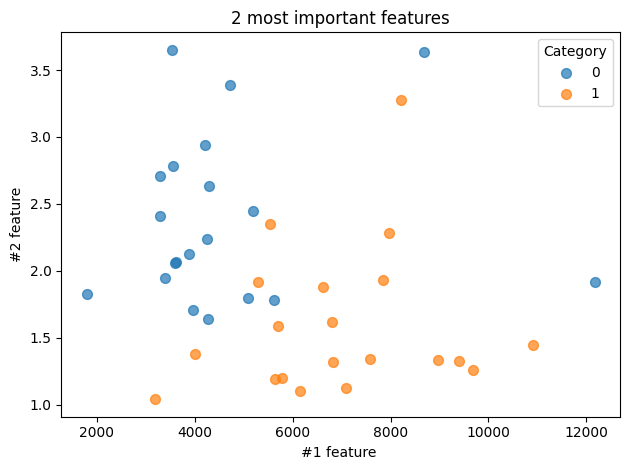

In [30]:
import matplotlib.pyplot as plt


df_binary = X_binary.copy()
# if y is a Series:
df_binary['category'] = y_binary
# if y is a single‐column DataFrame instead, use:
# df['category'] = y['category_column_name']

# --- Option A: matplotlib only ---
fig, ax = plt.subplots()
for cat, sub in df_binary.groupby('category'):
    ax.scatter(sub["ED_LV_vol"], sub['ED_RV_vol_div_ES_RV_vol'], label=cat, s=50, alpha=0.7)
ax.set_xlabel('#1 feature ')
ax.set_ylabel('#2 feature')
ax.set_title('2 most important features')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

In [31]:
# Get the per‐class probabilities for every sample
proba = inf_pipeline.predict_proba(X)

threshold = 0.4
L = [0,0, 0,0]        # just three slots since you only ever check classes 1 and 2
I = []               # this will collect the ROW indices where both class‐1 and class‐2 prob > th

for row_idx, probs in enumerate(proba):
    # find which classes exceed the threshold among 1 and 2
    hits = [cls for cls in (1, 2) if probs[cls] > threshold]
    if len(hits) >= 2:
        print(f"Row {row_idx} probs:", probs)
        # increment your L counters
        for cls in hits:
            L[cls] += 1
        # append the ROW index, not the class index
        I.append(row_idx)

# Now I is a list of valid positions in X
print("Selected rows:", I)

# Subset X properly
X_sel = X.iloc[I]
# X_sel = X_sel_1.drop(columns=feature_importance[:5]["feature"].to_list())

# Compare old vs. new pipeline on exactly those rows
old_class = inf_pipeline.predict(X_sel)
new_prob  = inf_pipeline_binary.predict_proba(X_sel)
new_class = le.inverse_transform(inf_pipeline_binary.predict(X_sel))

print("\nOld probs:\n", inf_pipeline.predict_proba(X_sel))
print("New probs:\n", new_prob)

print("\nOld preds:\n", old_class)
print("New preds:\n", new_class)
print("True class:\n",y.loc[X.index[I], "Category"].values)
print("\nCounts per class (1 & 2):", L[1], L[2])



Row 78 probs: [0.00090909 0.45372925 0.54536166 0.         0.        ]
Selected rows: [78]

Old probs:
 [[0.00090909 0.45372925 0.54536166 0.         0.        ]]
New probs:
 [[0.3965 0.6035]]

Old preds:
 [2]
New preds:
 [2]
True class:
 [1]

Counts per class (1 & 2): 1 1


# REPREDICTING PREDICTION THAT HAVE LOW PROBABILITIES

In [25]:
import os
import numpy as np
import pandas as pd

# 1) --- Baseline submission (before binary adjustments) ---
y_pred_before = inf_pipeline.predict(X_test)
submission_before = pd.DataFrame({
    "Id":       X_test.index + 101,
    "Category": y_pred_before
})
submission_before.to_csv("submission_19_before.csv", index=False)
print("Saved baseline submission to submission_19_before.csv\n")

# 2) --- Find ambiguous rows in the test set ---
proba_test = inf_pipeline.predict_proba(X_test)
threshold = 0.35
I_test = [
    i for i, probs in enumerate(proba_test)
    if sum(probs[c] > threshold for c in (1, 2)) >= 2
]

if not I_test:
    print(f"No ambiguous rows found (both P(1) and P(2) > {treshold}).")
    new_preds = []
else:
    print("Ambiguous rows (both P(1)&P(2)>0.4):", I_test)
    # counters for how many times each class exceeds threshold
    L = {1: 0, 2: 0}
    for row_idx in I_test:
        probs = proba_test[row_idx]
        hits = [c for c in (1, 2) if probs[c] > threshold]
        print(f"Row {row_idx} probs: {probs}")
        for c in hits:
            L[c] += 1

    # old vs new on those rows
    X_sel    = X_test.iloc[I_test]
    # X_sel = X_sel_2.drop(columns=feature_importance[:5]["feature"].to_list())
    old_probs = inf_pipeline.predict_proba(X_sel)
    old_preds = inf_pipeline.predict(X_sel)
    new_probs = inf_pipeline_binary.predict_proba(X_sel)
    new_preds = le.inverse_transform(inf_pipeline_binary.predict(X_sel))

    print("\nOld probs:\n", old_probs)
    print("New probs:\n", new_probs)
    print("\nOld preds:\n", old_preds)
    print("New preds:\n", new_preds)
    print(f"\nCounts per class>thr (1 & 2): {L[1]}, {L[2]}\n")

# 3) --- Build and save the “after” submission ---
y_pred_after = y_pred_before.copy()
if I_test:
    for loc, new_lab in zip(I_test, new_preds):
        y_pred_after[loc] = new_lab

submission_after = pd.DataFrame({
    "Id":       X_test.index + 101,
    "Category": y_pred_after
})
submission_after.to_csv("submission_19_after.csv", index=False)
print("Saved updated submission to submission_19_after.csv")


Saved baseline submission to submission_19_before.csv

Ambiguous rows (both P(1)&P(2)>0.4): [8, 12, 21, 37]
Row 8 probs: [0.0865     0.36250163 0.39249837 0.094      0.0645    ]
Row 12 probs: [0.01083333 0.49109687 0.44140313 0.02       0.03666667]
Row 21 probs: [0.07483333 0.37743271 0.46173395 0.039      0.047     ]
Row 37 probs: [0.00674242 0.5380889  0.45433534 0.         0.00083333]

Old probs:
 [[0.0865     0.36250163 0.39249837 0.094      0.0645    ]
 [0.01083333 0.49109687 0.44140313 0.02       0.03666667]
 [0.07483333 0.37743271 0.46173395 0.039      0.047     ]
 [0.00674242 0.5380889  0.45433534 0.         0.00083333]]
New probs:
 [[0.86235594 0.13764406]
 [0.7010345  0.2989655 ]
 [0.80234429 0.19765571]
 [0.41361009 0.58638991]]

Old preds:
 [2 1 2 1]
New preds:
 [1 1 1 2]

Counts per class>thr (1 & 2): 4, 4

Saved updated submission to submission_19_after.csv


In [69]:
import joblib
from datetime import datetime
import os

# Create a timestamp
currentDateTime = datetime.now()

# Get the base directory (current directory)
BASE_DIR = os.getcwd()
print(f"BASE_DIR: {BASE_DIR}")
RESULT_DIR = os.path.join(BASE_DIR,"output")
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
    print(f"Directory created: {RESULT_DIR}")

# Create a folder named 'pipeline_<timestamp>' in the current directory
dir_name = name_folder
dir_path = os.path.join(RESULT_DIR, dir_name)

# If the directory doesn't exist, create it
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
    print(f"Directory created: {dir_path}")

# Save the model inside this new folder
model_filename = 'pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.pkl'
model_path = os.path.join(dir_path, model_filename)

# This is where you'd have your model defined
joblib.dump(grid_search, model_path)
print(f"Model saved to: {model_path}")


# Saving feature importance : 
feature_importance_filename ='pipeline_' + currentDateTime.strftime("%H-%M-%S") + '.csv' 
feature_importance_dir = os.path.join(dir_path,feature_importance_filename)
feature_importance.to_csv(feature_importance_dir)


# SAVING Description 
dict_filename = 'params.txt'
dict_path = os.path.join(dir_path, dict_filename)

with open(dict_path, 'w') as f:
    for key, val in informationDict.items():
        f.write(f"{key} : {val}\n")
print(f"Information about the model saved to: {dict_path}")


BASE_DIR: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction
Directory created: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_1
Model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_1/pipeline_20-14-16.pkl
Information about the model saved to: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/output/RF_1/params.txt
